<a href="https://colab.research.google.com/github/snpsuen/Kubeflow_quickstart/blob/main/artifact/Pytorch_RNN_LSTM_AT_example05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
print("(1) Reading airline passengers CSV ...")
print("")
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
print("Type of df = ", type(df))
print("df.shape = ", df.shape)
timeseries = df[["Passengers"]].values.astype('float32')
print("Type of timeseries = ", type(timeseries))
print("timeseries.shape = ", timeseries.shape)

(1) Reading airline passengers CSV ...

Type of df =  <class 'pandas.core.frame.DataFrame'>
df.shape =  (144, 2)
Type of timeseries =  <class 'numpy.ndarray'>
timeseries.shape =  (144, 1)


In [3]:
proportion = 0.70
lookback = 4
train_size = int(len(timeseries) * proportion)
test_size = len(timeseries) - train_size
train, test, forecast = timeseries[:train_size], timeseries[train_size:], timeseries[-lookback:]

print("Type of train = ", type(train))
print("train.shape = ", train.shape)
print("Type of test = ", type(test))
print("test.shape = ", test.shape)
print("Type of forecast = ", type(forecast))
print("forecast.shape = ", forecast.shape)

Type of train =  <class 'numpy.ndarray'>
train.shape =  (100, 1)
Type of test =  <class 'numpy.ndarray'>
test.shape =  (44, 1)
Type of forecast =  <class 'numpy.ndarray'>
forecast.shape =  (4, 1)


In [4]:
print("(2) Preparing DL training and testing datasets ...")
print("")

def create_dataset(numarray, lookback):
    """Transform a time series into a prediction dataset

    Args:
        numarray: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(numarray)-lookback):
        feature = numarray[i:i+lookback]
        target = numarray[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_forecast = torch.tensor(forecast.reshape(1, -1, 1))

print("Type of X_train, type of y_train = ", type(X_train), type(y_train))
print("X_train.shape(samples, timesteps, features), y_train.shape(samples, features) = ", X_train.shape, y_train.shape)
print("Type of X_test, type of y_test = ", type(X_train), type(y_train))
print("X_test.shape(samples, timesteps, features), y_test.shape(samples, features) = ", X_test.shape, y_test.shape)
print("Type of X_forecast = ", type(X_forecast))
print("X_forecast.shape(samples, timesteps, features) = ", X_forecast.shape)

(2) Preparing DL training and testing datasets ...

Type of X_train, type of y_train =  <class 'torch.Tensor'> <class 'torch.Tensor'>
X_train.shape(samples, timesteps, features), y_train.shape(samples, features) =  torch.Size([96, 4, 1]) torch.Size([96, 1])
Type of X_test, type of y_test =  <class 'torch.Tensor'> <class 'torch.Tensor'>
X_test.shape(samples, timesteps, features), y_test.shape(samples, features) =  torch.Size([40, 4, 1]) torch.Size([40, 1])
Type of X_forecast =  <class 'torch.Tensor'>
X_forecast.shape(samples, timesteps, features) =  torch.Size([1, 4, 1])


In [5]:
print("(3) Setting up an RNN LSTM model ...")
print("")

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=50, out_features=1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
mseloss = nn.MSELoss()
trainloader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

(3) Setting up an RNN LSTM model ...



In [6]:
print("(4) Training and evaluating the model ...")
print("")

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in trainloader:
        y_pred = model(X_batch)
        loss = mseloss(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 != 0:
        continue

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(mseloss(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(mseloss(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

(4) Training and evaluating the model ...



/tmp/ipython-input-6-4125457189.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(mseloss(y_pred, y_train))
/tmp/ipython-input-6-4125457189.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(mseloss(y_pred, y_test))


Epoch 0: train RMSE 233.5489, test RMSE 427.3872
Epoch 10: train RMSE 225.2196, test RMSE 418.7727
Epoch 20: train RMSE 218.5735, test RMSE 411.8629
Epoch 30: train RMSE 212.7854, test RMSE 405.8306
Epoch 40: train RMSE 207.4868, test RMSE 400.2926
Epoch 50: train RMSE 202.4110, test RMSE 394.9719
Epoch 60: train RMSE 197.5094, test RMSE 389.8178
Epoch 70: train RMSE 192.7283, test RMSE 384.7739
Epoch 80: train RMSE 188.0657, test RMSE 379.8378
Epoch 90: train RMSE 183.4943, test RMSE 374.9803


In [7]:
print("(5) Forecasting from the model ...")
print("")

with torch.no_grad():
  y_forecast = model(X_forecast)

print("Forecast input = ", X_forecast)
print("Forecast output = ", y_forecast)

(5) Forecasting from the model ...

Forecast input =  tensor([[[508.],
         [461.],
         [390.],
         [432.]]])
Forecast output =  tensor([[58.2607]])


(6) Plotting the model ...



/tmp/ipython-input-10-662216539.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)
/tmp/ipython-input-10-662216539.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)


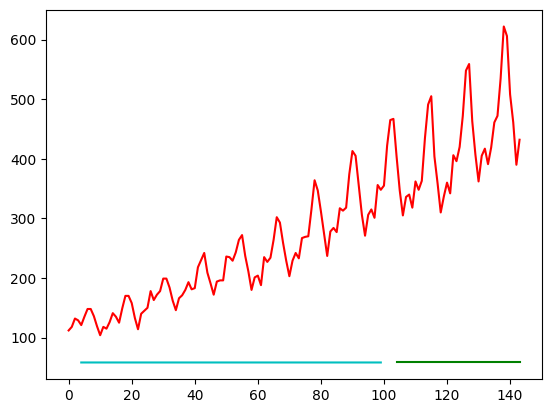

In [10]:
print("(6) Plotting the model ...")
print("")

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    # y_pred = model(X_train)
    # y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)

    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)
# plot
plt.plot(timeseries, c='r')
plt.plot(train_plot, c='c')
plt.plot(test_plot, c='g')
plt.show(block=True)